# EDA 03 — Bivariate correlations & redundancy (feature blocks)

This notebook:
- Uses explicit column roles (label/meta/features) consistent with EDA 01–02
- Computes Pearson and Spearman correlation matrices on descriptor features only
- Visualizes clustered correlation heatmaps (seaborn clustermap)
- Identifies highly correlated feature blocks (redundancy)
- Suggests a pruning list (keep 1 representative per block)
- Exports correlation matrices, blocks, and pruning suggestions

Outputs:
- Figures: `results/eda/figures/correlations/`
- Tables: `results/eda/stats/`


In [26]:
from __future__ import annotations

from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
sns.set_context("notebook")
sns.set_style("white")

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 300

PROJECT_ROOT = Path("../../").resolve()

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed_variants"
STRICT_CSV  = DATA_PROCESSED_DIR / "hcs_strict_complete_case_20260129_114259.csv"
IMPUTED_CSV = DATA_PROCESSED_DIR / "hcs_imputed_exploratory_20260129_114259.csv"

EDA_ROOT = PROJECT_ROOT / "results" / "eda"
FIG_DIR = EDA_ROOT / "figures" / "correlations"
STATS_DIR = EDA_ROOT / "stats"

FIG_DIR.mkdir(parents=True, exist_ok=True)
STATS_DIR.mkdir(parents=True, exist_ok=True)

print("FIG_DIR:", FIG_DIR)
print("STATS_DIR:", STATS_DIR)


FIG_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations
STATS_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats


In [28]:
def load_dataset(path: Path) -> pd.DataFrame:
    """
    Load a dataset from disk (CSV).

    Parameters
    ----------
    path : Path
        Path to a CSV file.

    Returns
    -------
    pd.DataFrame
        Loaded dataframe.
    """
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found: {path}")
    return pd.read_csv(path)


df_strict = load_dataset(STRICT_CSV)
df_imputed = load_dataset(IMPUTED_CSV)

print("STRICT:", df_strict.shape)
print("IMPUTED:", df_imputed.shape)

STRICT: (148, 15)
IMPUTED: (160, 15)


In [29]:
# ============================================================
# EXPLICIT COLUMN DEFINITIONS
# ============================================================

LABEL_COL = "MSPH"     

META_COLS = [
    "row_id", "_sheet", "LocalID"	
]

USE_AUTO_FEATURES = True
MANUAL_FEATURE_COLS: List[str] = []

# ============================================================

def resolve_columns(df: pd.DataFrame) -> tuple[str, List[str], List[str]]:
    """
    Resolve label, metadata and feature columns using explicit user definitions.

    Returns
    -------
    (label_col, meta_cols_present, feature_cols)
    """
    if LABEL_COL not in df.columns:
        raise ValueError(f"LABEL_COL='{LABEL_COL}' not found in dataframe columns.")

    meta_present = [c for c in META_COLS if c in df.columns]

    if USE_AUTO_FEATURES:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in numeric_cols if c not in blacklist]
    else:
        if not MANUAL_FEATURE_COLS:
            raise ValueError("USE_AUTO_FEATURES=False but MANUAL_FEATURE_COLS is empty.")
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in MANUAL_FEATURE_COLS if (c in df.columns and c not in blacklist)]

    if not feature_cols:
        raise ValueError("No feature columns resolved. Check LABEL_COL/META_COLS.")

    return LABEL_COL, meta_present, feature_cols


label_s, meta_s, feat_s = resolve_columns(df_strict)
label_i, meta_i, feat_i = resolve_columns(df_imputed)

print("Resolved (strict) features:", len(feat_s))
print("Resolved (imputed) features:", len(feat_i))


Resolved (strict) features: 11
Resolved (imputed) features: 11


In [30]:
def load_feature_set_from_stats(path: Path) -> Optional[List[str]]:
    """
    Load a feature set list from a CSV with a 'feature' column.

    Parameters
    ----------
    path : Path
        Path to a CSV file.

    Returns
    -------
    Optional[List[str]]
        Feature list if file exists, else None.
    """
    if not path.exists():
        return None
    df = pd.read_csv(path)
    if "feature" not in df.columns:
        return None
    return df["feature"].dropna().astype(str).tolist()


# Prefer the feature_set_v1 produced by Notebook 02, if available
feature_set_v1_path = STATS_DIR / "feature_set_v1.csv"
features_v1 = load_feature_set_from_stats(feature_set_v1_path)

if features_v1 is None:
    print("feature_set_v1.csv not found. Falling back to strict∩imputed features inferred from this notebook.")
    features_v1 = sorted(list(set(feat_s).intersection(set(feat_i))))
else:
    print("Loaded feature_set_v1.csv:", len(features_v1))

# Ensure they exist in both datasets
features_v1 = [f for f in features_v1 if (f in df_strict.columns and f in df_imputed.columns)]
print("Final correlation feature set size:", len(features_v1))

pd.DataFrame({"feature": features_v1}).to_csv(STATS_DIR / "feature_set_used_for_correlations.csv", index=False)
print("Saved:", STATS_DIR / "feature_set_used_for_correlations.csv")


Loaded feature_set_v1.csv: 11
Final correlation feature set size: 11
Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/feature_set_used_for_correlations.csv


In [31]:
def prepare_numeric_matrix(df: pd.DataFrame, feature_cols: List[str]) -> pd.DataFrame:
    """
    Prepare a numeric matrix for correlation analysis.

    Notes
    -----
    - Uses only feature columns.
    - Coerces to numeric (errors -> NaN).
    - Drops columns that become entirely NaN.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    feature_cols : List[str]
        Feature columns.

    Returns
    -------
    pd.DataFrame
        Numeric matrix for correlations.
    """
    X = df[feature_cols].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    # drop all-NaN columns
    X = X.dropna(axis=1, how="all")
    return X


X_strict = prepare_numeric_matrix(df_strict, features_v1)
X_imputed = prepare_numeric_matrix(df_imputed, features_v1)

print("X_strict:", X_strict.shape)
print("X_imputed:", X_imputed.shape)

# (Optional) align to common cols in case any were dropped
common_cols = sorted(list(set(X_strict.columns).intersection(set(X_imputed.columns))))
X_strict = X_strict[common_cols]
X_imputed = X_imputed[common_cols]
print("Aligned common cols:", len(common_cols))

X_strict: (148, 11)
X_imputed: (160, 11)
Aligned common cols: 11


In [32]:
def compute_corr(df_num: pd.DataFrame, method: str) -> pd.DataFrame:
    """
    Compute a correlation matrix.

    Parameters
    ----------
    df_num : pd.DataFrame
        Numeric matrix (features only).
    method : str
        Correlation method ('pearson' or 'spearman').

    Returns
    -------
    pd.DataFrame
        Correlation matrix.
    """
    return df_num.corr(method=method)


corr_p_strict = compute_corr(X_strict, "pearson")
corr_s_strict = compute_corr(X_strict, "spearman")

corr_p_imputed = compute_corr(X_imputed, "pearson")
corr_s_imputed = compute_corr(X_imputed, "spearman")

# Save matrices
corr_p_strict.to_csv(STATS_DIR / "corr_pearson_strict.csv")
corr_s_strict.to_csv(STATS_DIR / "corr_spearman_strict.csv")
corr_p_imputed.to_csv(STATS_DIR / "corr_pearson_imputed.csv")
corr_s_imputed.to_csv(STATS_DIR / "corr_spearman_imputed.csv")

print("Saved correlation matrices to stats/.")


Saved correlation matrices to stats/.


In [33]:
def plot_clustermap(
    corr: pd.DataFrame,
    dataset_name: str,
    method_name: str,
    figsize: Tuple[int, int] = (14, 14),
    show: bool = True,
    # ---- new controls ----
    show_feature_labels: str = "auto",   # {"auto","always","never"}
    annot: str = "auto",                # {"auto","always","never"}
    annot_fmt: str = ".2f",
    annot_threshold_n: int = 30,        # annotate only if n_features <= this (when annot="auto")
    label_threshold_n: int = 60,        # show tick labels only if n_features <= this (when show_feature_labels="auto")
    dendrogram_ratio: Tuple[float, float] = (0.12, 0.12),
    cbar_pos: Tuple[float, float, float, float] = (0.02, 0.85, 0.03, 0.12),
) -> Path:
    """
    Plot and save a seaborn clustered correlation heatmap with descriptor labels and optional annotations.

    Notes
    -----
    - For large matrices, full cell annotation becomes unreadable and expensive.
      Use `annot="auto"` to only annotate when the number of features is small.
    - Feature tick labels can be automatically hidden for large matrices.

    Parameters
    ----------
    corr : pd.DataFrame
        Correlation matrix (square, indexed by feature names).
    dataset_name : str
        Dataset identifier (e.g., 'strict', 'imputed').
    method_name : str
        Correlation method name (e.g., 'spearman', 'pearson').
    figsize : Tuple[int, int]
        Figure size passed to seaborn clustermap.
    show : bool
        Whether to display the plot in notebook.
    show_feature_labels : str
        Control tick labels: 'auto', 'always', or 'never'.
    annot : str
        Control numeric cell annotations: 'auto', 'always', or 'never'.
    annot_fmt : str
        Numeric format string for annotations.
    annot_threshold_n : int
        When annot='auto', annotate only if n_features <= this value.
    label_threshold_n : int
        When show_feature_labels='auto', show labels only if n_features <= this value.
    dendrogram_ratio : Tuple[float, float]
        Size of dendrograms (row, col) relative to heatmap.
    cbar_pos : Tuple[float, float, float, float]
        Colorbar position (x, y, width, height) in figure coordinates.

    Returns
    -------
    Path
        Path to the saved figure.
    """
    # sanitize
    corr = corr.copy()
    corr = corr.loc[corr.index, corr.columns]  # ensure aligned
    n = corr.shape[0]

    # label logic
    if show_feature_labels not in {"auto", "always", "never"}:
        raise ValueError("show_feature_labels must be one of: {'auto','always','never'}")
    if annot not in {"auto", "always", "never"}:
        raise ValueError("annot must be one of: {'auto','always','never'}")

    if show_feature_labels == "always":
        xticklabels = True
        yticklabels = True
    elif show_feature_labels == "never":
        xticklabels = False
        yticklabels = False
    else:
        # auto
        xticklabels = (n <= label_threshold_n)
        yticklabels = (n <= label_threshold_n)

    # annotation logic
    if annot == "always":
        do_annot = True
    elif annot == "never":
        do_annot = False
    else:
        do_annot = (n <= annot_threshold_n)

    # Build the clustermap
    g = sns.clustermap(
        corr,
        cmap="vlag",
        center=0,
        vmin=-1,
        vmax=1,
        figsize=figsize,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        dendrogram_ratio=dendrogram_ratio,
        cbar_pos=cbar_pos,
        linewidths=0.0,
    )

    # Improve tick label readability if shown
    if xticklabels:
        plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha="center", fontsize=7)
    if yticklabels:
        plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=7)

    # Add numeric annotations on the heatmap (optional)
    if do_annot:
        # Reorder correlation matrix to match clustered order
        row_order = g.dendrogram_row.reordered_ind
        col_order = g.dendrogram_col.reordered_ind
        corr_reordered = corr.iloc[row_order, col_order]

        # Annotate on the heatmap axis
        ax = g.ax_heatmap
        for i in range(corr_reordered.shape[0]):
            for j in range(corr_reordered.shape[1]):
                val = corr_reordered.iat[i, j]
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    format(val, annot_fmt),
                    ha="center",
                    va="center",
                    fontsize=10,
                )

    # Titles
    g.fig.suptitle(
        f"{method_name.title()} correlation (features) — {dataset_name} (n={n})",
        y=1.02,
        fontsize=12,
    )
    g.ax_heatmap.set_xlabel("Descriptors" if xticklabels else "")
    g.ax_heatmap.set_ylabel("Descriptors" if yticklabels else "")

    out = FIG_DIR / f"clustermap_{method_name}_{dataset_name}_n{n}.png"
    g.fig.savefig(out, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(g.fig)

    print("Saved:", out)
    return out

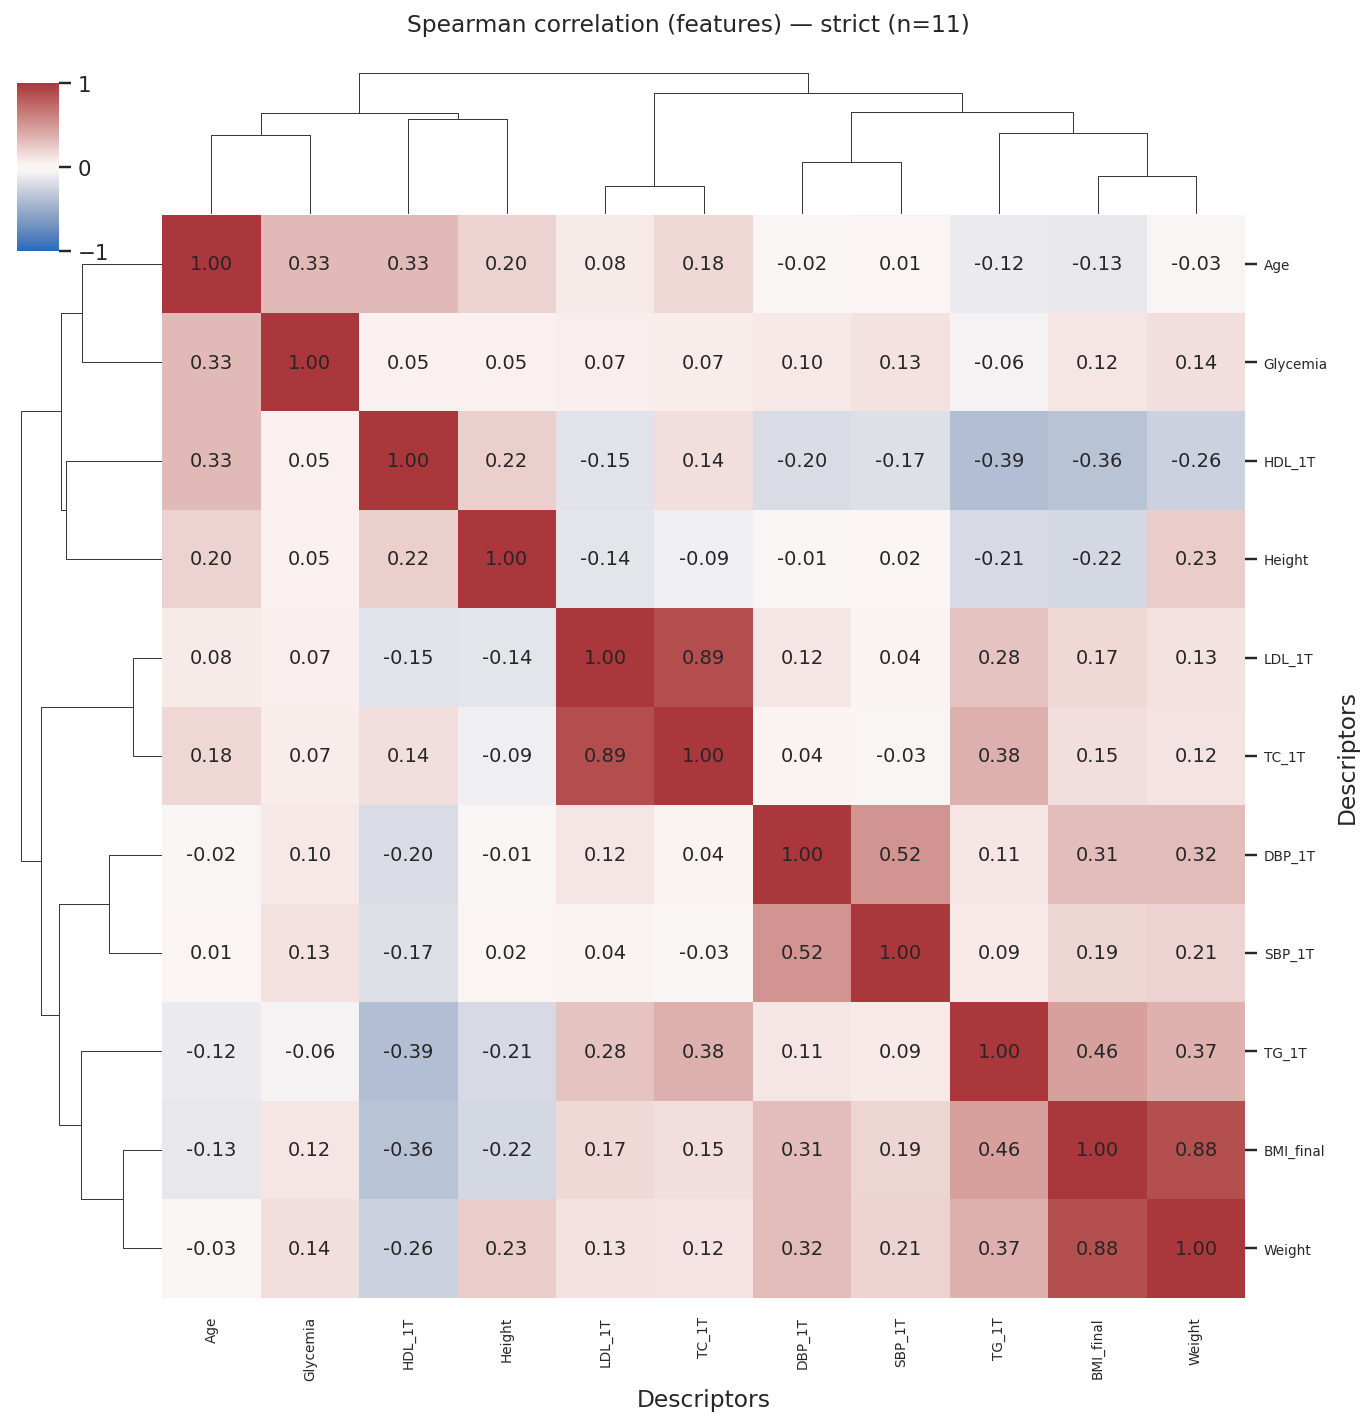

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations/clustermap_spearman_strict_n11.png


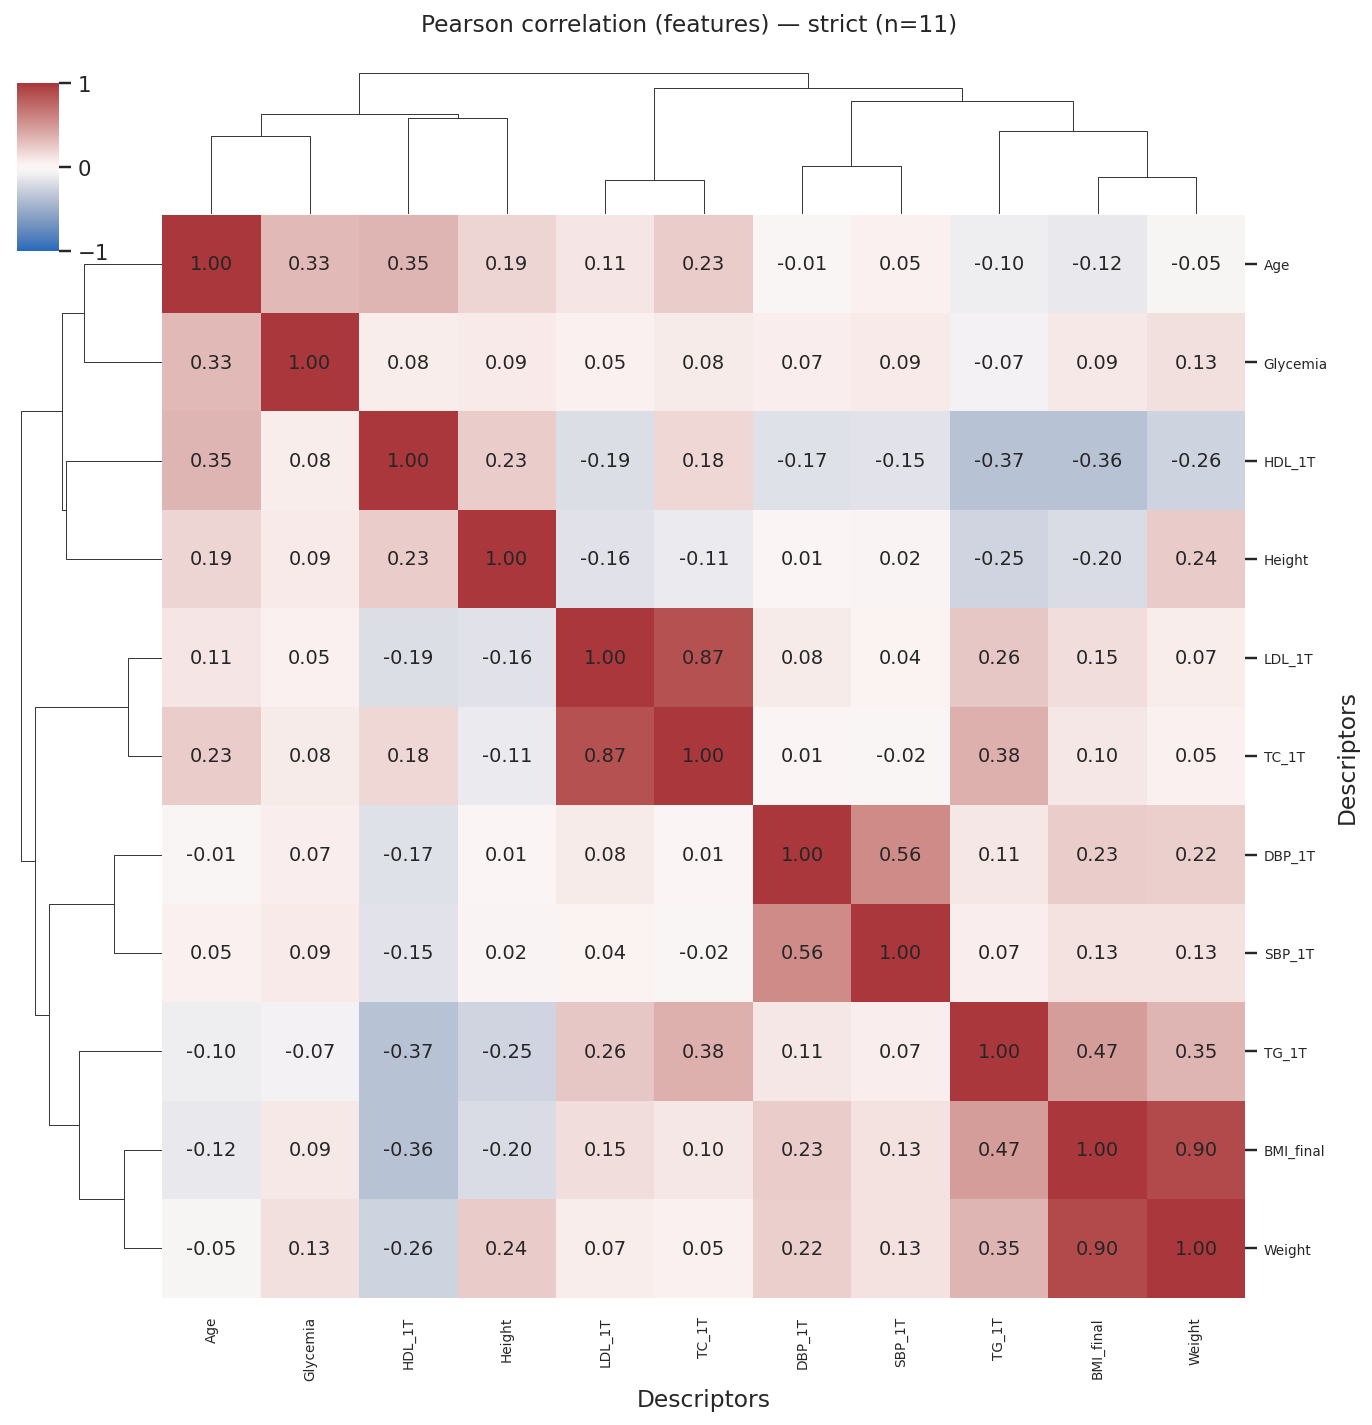

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations/clustermap_pearson_strict_n11.png


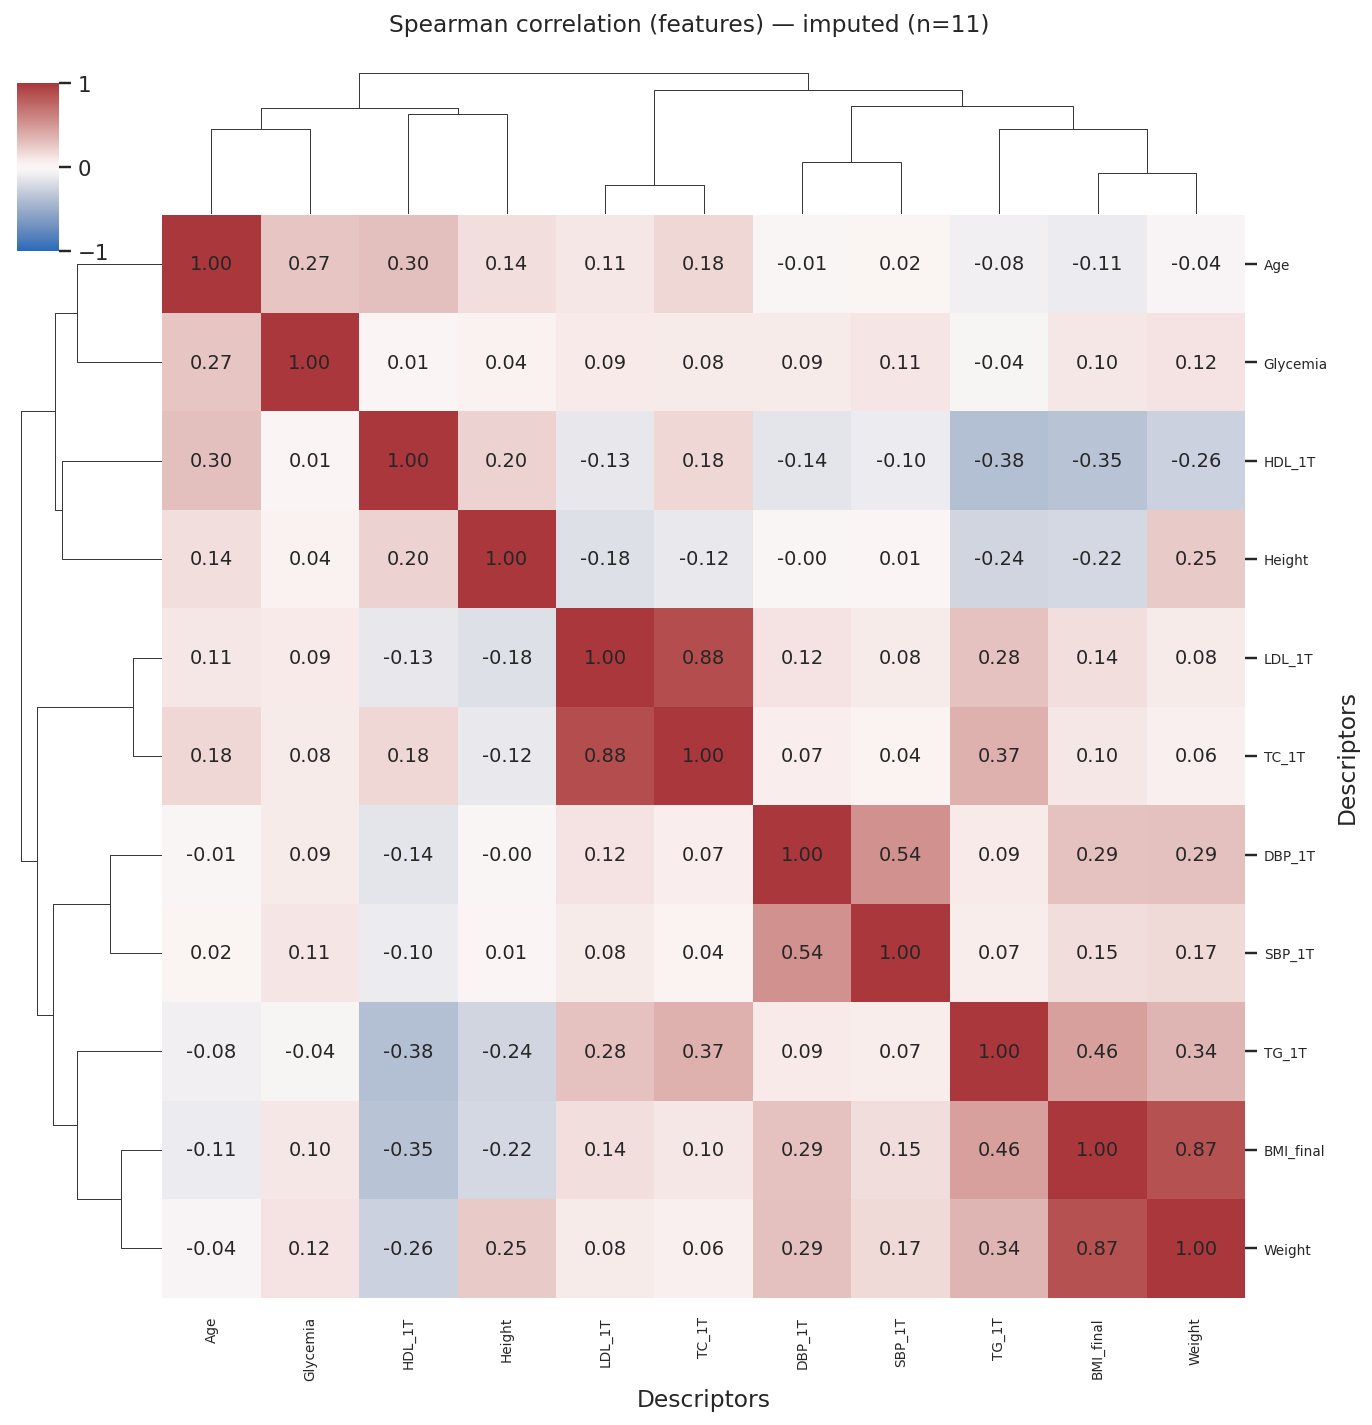

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations/clustermap_spearman_imputed_n11.png


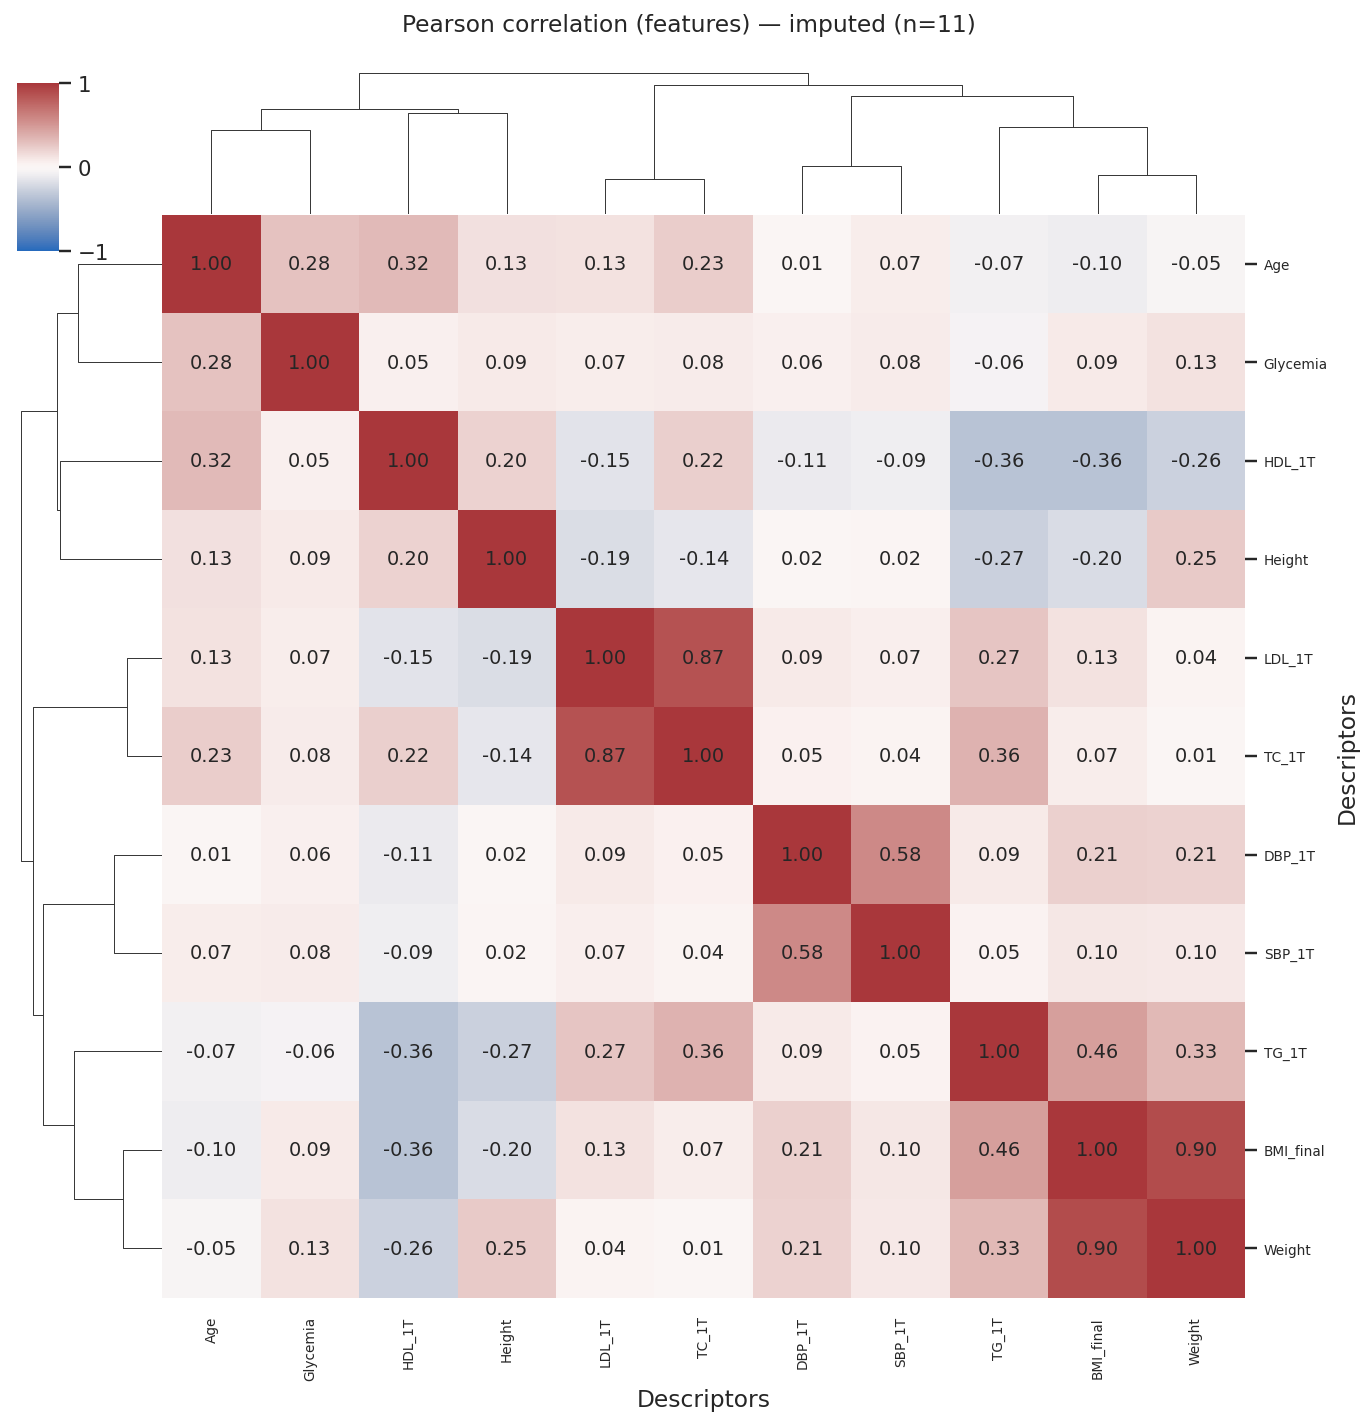

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations/clustermap_pearson_imputed_n11.png


PosixPath('/home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/correlations/clustermap_pearson_imputed_n11.png')

In [34]:
plot_clustermap(corr_s_strict, "strict", "spearman", figsize=(10, 10))
plot_clustermap(corr_p_strict, "strict", "pearson", figsize=(10, 10))

plot_clustermap(corr_s_imputed, "imputed", "spearman", figsize=(10, 10))
plot_clustermap(corr_p_imputed, "imputed", "pearson", figsize=(10, 10))


In [35]:
def corr_pairs(corr: pd.DataFrame, threshold: float = 0.9, abs_val: bool = True) -> pd.DataFrame:
    """
    Extract feature pairs with high correlation.

    Parameters
    ----------
    corr : pd.DataFrame
        Correlation matrix (square).
    threshold : float
        Minimum correlation magnitude to report.
    abs_val : bool
        If True, use absolute correlation.

    Returns
    -------
    pd.DataFrame
        Table with columns: feature_a, feature_b, corr.
    """
    c = corr.copy()
    if abs_val:
        c = c.abs()

    # upper triangle only (exclude diagonal)
    iu = np.triu_indices_from(c.values, k=1)
    vals = c.values[iu]
    mask = vals >= threshold

    a = c.index.to_numpy()[iu[0]][mask]
    b = c.columns.to_numpy()[iu[1]][mask]
    v = vals[mask]

    out = pd.DataFrame({"feature_a": a, "feature_b": b, "corr_abs": v})
    out = out.sort_values("corr_abs", ascending=False).reset_index(drop=True)
    return out


THRESH = 0.80
pairs_strict = corr_pairs(corr_s_strict, threshold=THRESH, abs_val=True)
pairs_imputed = corr_pairs(corr_s_imputed, threshold=THRESH, abs_val=True)

display(pairs_strict.head(25))
display(pairs_imputed.head(25))

pairs_strict.to_csv(STATS_DIR / f"highcorr_pairs_spearman_strict_thr{THRESH:.2f}.csv", index=False)
pairs_imputed.to_csv(STATS_DIR / f"highcorr_pairs_spearman_imputed_thr{THRESH:.2f}.csv", index=False)

print("Saved high-correlation pair tables.")


,feature_a,feature_b,corr_abs
0,LDL_1T,TC_1T,0.890282
1,BMI_final,Weight,0.877051


,feature_a,feature_b,corr_abs
0,LDL_1T,TC_1T,0.884723
1,BMI_final,Weight,0.871035


Saved high-correlation pair tables.


In [36]:
def build_correlation_blocks(pairs: pd.DataFrame) -> List[List[str]]:
    """
    Build redundancy blocks as connected components from a high-correlation edge list.

    Parameters
    ----------
    pairs : pd.DataFrame
        Output from `corr_pairs` with columns feature_a, feature_b.

    Returns
    -------
    List[List[str]]
        List of blocks, each a list of feature names.
    """
    # Build adjacency
    adj: Dict[str, set] = {}
    for _, r in pairs.iterrows():
        a, b = r["feature_a"], r["feature_b"]
        adj.setdefault(a, set()).add(b)
        adj.setdefault(b, set()).add(a)

    visited = set()
    blocks: List[List[str]] = []

    for node in adj.keys():
        if node in visited:
            continue
        stack = [node]
        comp = []
        visited.add(node)

        while stack:
            u = stack.pop()
            comp.append(u)
            for v in adj.get(u, []):
                if v not in visited:
                    visited.add(v)
                    stack.append(v)

        if len(comp) >= 2:
            blocks.append(sorted(comp))

    # sort blocks by size (desc)
    blocks.sort(key=len, reverse=True)
    return blocks


blocks_strict = build_correlation_blocks(pairs_strict)
blocks_imputed = build_correlation_blocks(pairs_imputed)

print("Blocks (strict):", len(blocks_strict), " top sizes:", [len(b) for b in blocks_strict[:5]])
print("Blocks (imputed):", len(blocks_imputed), " top sizes:", [len(b) for b in blocks_imputed[:5]])

# Export blocks
def export_blocks(blocks: List[List[str]], dataset_name: str, threshold: float) -> Path:
    """
    Export correlation blocks to a tidy CSV: block_id, feature.

    Returns
    -------
    Path
        Output file path.
    """
    rows = []
    for i, block in enumerate(blocks, start=1):
        for f in block:
            rows.append({"dataset": dataset_name, "threshold": threshold, "block_id": i, "feature": f, "block_size": len(block)})
    out = pd.DataFrame(rows)
    path = STATS_DIR / f"corr_blocks_{dataset_name}_spearman_thr{threshold:.2f}.csv"
    out.to_csv(path, index=False)
    return path

path_blocks_strict = export_blocks(blocks_strict, "strict", THRESH)
path_blocks_imputed = export_blocks(blocks_imputed, "imputed", THRESH)

print("Saved:", path_blocks_strict)
print("Saved:", path_blocks_imputed)


Blocks (strict): 2  top sizes: [2, 2]
Blocks (imputed): 2  top sizes: [2, 2]
Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/corr_blocks_strict_spearman_thr0.80.csv
Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/corr_blocks_imputed_spearman_thr0.80.csv


In [37]:
def feature_quality_table(df: pd.DataFrame, features: List[str], dataset_name: str) -> pd.DataFrame:
    """
    Build a simple feature quality table with variance and missingness.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    features : List[str]
        Feature list.
    dataset_name : str
        Dataset identifier.

    Returns
    -------
    pd.DataFrame
        Table with missingness_pct and variance.
    """
    X = df[features].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    miss_pct = (X.isna().sum() / max(len(X), 1)) * 100.0
    var = X.var(axis=0, skipna=True)

    out = pd.DataFrame({
        "dataset": dataset_name,
        "feature": features,
        "missing_pct": miss_pct.values,
        "variance": var.values,
    }).sort_values(["missing_pct", "variance"], ascending=[True, False]).reset_index(drop=True)
    return out


qual_strict = feature_quality_table(df_strict, common_cols, "strict")
qual_imputed = feature_quality_table(df_imputed, common_cols, "imputed")

qual_strict.to_csv(STATS_DIR / "feature_quality_strict.csv", index=False)
qual_imputed.to_csv(STATS_DIR / "feature_quality_imputed.csv", index=False)

print("Saved feature quality tables.")
display(qual_strict.head(15))


Saved feature quality tables.


,dataset,feature,missing_pct,variance
0,strict,TG_1T,0.0,1965.838097
1,strict,TC_1T,0.0,821.762227
2,strict,LDL_1T,0.0,673.485580
3,strict,HDL_1T,0.0,174.976971
4,strict,Weight,0.0,159.613294
5,strict,SBP_1T,0.0,102.340274
6,strict,Glycemia,0.0,84.587337
7,strict,DBP_1T,0.0,82.872035
8,strict,Height,0.0,44.188638
9,strict,Age,0.0,32.529877


In [38]:
def recommend_pruning(
    blocks: List[List[str]],
    quality: pd.DataFrame,
    dataset_name: str,
    strategy: str = "min_missing_then_max_variance",
) -> pd.DataFrame:
    """
    Recommend redundancy pruning by selecting one representative feature per block.

    Parameters
    ----------
    blocks : List[List[str]]
        Correlation blocks.
    quality : pd.DataFrame
        Feature quality table containing missing_pct and variance.
    dataset_name : str
        Dataset identifier.
    strategy : str
        Selection strategy.

    Returns
    -------
    pd.DataFrame
        Table with block_id, keep_feature, drop_feature, reason.
    """
    q = quality.set_index("feature")[["missing_pct", "variance"]]

    rows = []
    for i, block in enumerate(blocks, start=1):
        block_q = q.loc[[f for f in block if f in q.index]].copy()
        if block_q.empty:
            continue

        if strategy == "min_missing_then_max_variance":
            # sort: lowest missingness, highest variance
            block_q = block_q.sort_values(["missing_pct", "variance"], ascending=[True, False])
        else:
            block_q = block_q.sort_values(["variance", "missing_pct"], ascending=[False, True])

        keep = block_q.index[0]
        for f in block:
            if f == keep:
                continue
            rows.append({
                "dataset": dataset_name,
                "block_id": i,
                "block_size": len(block),
                "keep_feature": keep,
                "drop_feature": f,
                "keep_missing_pct": float(block_q.loc[keep, "missing_pct"]),
                "keep_variance": float(block_q.loc[keep, "variance"]),
                "drop_missing_pct": float(q.loc[f, "missing_pct"]) if f in q.index else np.nan,
                "drop_variance": float(q.loc[f, "variance"]) if f in q.index else np.nan,
                "strategy": strategy,
                "threshold": THRESH,
            })

    out = pd.DataFrame(rows)
    # Larger blocks first, then by keep feature name
    out = out.sort_values(["block_size", "block_id"], ascending=[False, True]).reset_index(drop=True)
    return out


prune_strict = recommend_pruning(blocks_strict, qual_strict, "strict")
prune_imputed = recommend_pruning(blocks_imputed, qual_imputed, "imputed")

display(prune_strict.head(30))
display(prune_imputed.head(30))

prune_strict.to_csv(STATS_DIR / f"pruning_recommendations_strict_thr{THRESH:.2f}.csv", index=False)
prune_imputed.to_csv(STATS_DIR / f"pruning_recommendations_imputed_thr{THRESH:.2f}.csv", index=False)

print("Saved pruning recommendations.")


,dataset,block_id,block_size,keep_feature,drop_feature,keep_missing_pct,keep_variance,drop_missing_pct,drop_variance,strategy,threshold
0,strict,1,2,TC_1T,LDL_1T,0.0,821.762227,0.0,673.485580,min_missing_then_max_variance,0.8
1,strict,2,2,Weight,BMI_final,0.0,159.613294,0.0,23.264348,min_missing_then_max_variance,0.8


,dataset,block_id,block_size,keep_feature,drop_feature,keep_missing_pct,keep_variance,drop_missing_pct,drop_variance,strategy,threshold
0,imputed,1,2,TC_1T,LDL_1T,0.0,845.025000,0.0,698.041493,min_missing_then_max_variance,0.8
1,imputed,2,2,Weight,BMI_final,0.0,153.454263,0.0,22.258877,min_missing_then_max_variance,0.8


Saved pruning recommendations.


In [39]:
def feature_label_corr(df: pd.DataFrame, label_col: str, feature_cols: List[str], method: str = "spearman") -> pd.DataFrame:
    """
    Compute correlation between each feature and the label (univariate association proxy).

    Notes
    -----
    This is not a causal analysis; it is a quick screening signal.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    label_col : str
        Label column name.
    feature_cols : List[str]
        Feature columns.
    method : str
        Correlation method.

    Returns
    -------
    pd.DataFrame
        Table with feature and correlation value.
    """
    y = pd.to_numeric(df[label_col], errors="coerce")
    rows = []
    for f in feature_cols:
        x = pd.to_numeric(df[f], errors="coerce")
        tmp = pd.concat([x, y], axis=1).dropna()
        if tmp.shape[0] < 20:
            r = np.nan
        else:
            r = tmp.iloc[:, 0].corr(tmp.iloc[:, 1], method=method)
        rows.append({"feature": f, f"{method}_corr_with_label": r})
    out = pd.DataFrame(rows).sort_values(f"{method}_corr_with_label", ascending=False).reset_index(drop=True)
    return out


# You can toggle this on/off. It's useful to rank features for Notebook 04 stats.
DO_LABEL_SCREENING = True

if DO_LABEL_SCREENING:
    flc_strict = feature_label_corr(df_strict, label_s, common_cols, method="spearman")
    flc_imputed = feature_label_corr(df_imputed, label_i, common_cols, method="spearman")

    display(flc_strict.head(20))
    display(flc_imputed.head(20))

    flc_strict.to_csv(STATS_DIR / "feature_label_spearman_strict.csv", index=False)
    flc_imputed.to_csv(STATS_DIR / "feature_label_spearman_imputed.csv", index=False)
    print("Saved feature-label correlation screening tables.")


,feature,spearman_corr_with_label
0,TC_1T,0.437739
1,LDL_1T,0.402205
2,SBP_1T,0.179868
3,HDL_1T,0.175070
4,Age,0.168403
5,Height,0.062349
6,DBP_1T,0.045079
7,TG_1T,-0.021576
8,Glycemia,-0.043331
9,Weight,-0.110984


,feature,spearman_corr_with_label
0,TC_1T,0.437720
1,LDL_1T,0.391712
2,SBP_1T,0.197321
3,HDL_1T,0.187772
4,Age,0.141054
5,DBP_1T,0.043551
6,Height,0.027612
7,TG_1T,-0.013032
8,Glycemia,-0.038950
9,Weight,-0.133028


Saved feature-label correlation screening tables.


## Notes for Notebook 04 (Group comparisons / statistical testing)

With redundancy blocks available, Notebook 04 should:
- Use a pruned feature set (one representative per block) to reduce multiple-testing burden
- Compare feature distributions across label groups:
  - Mann–Whitney U (binary label) or Kruskal–Wallis (multi-class)
  - Effect sizes (Cliff's delta / rank-biserial)
  - Multiple testing correction (FDR)
- Produce a ranked table and a compact figure (effect-size plot / volcano-style)